In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=4000)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)
        
        
import os
import random
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
from skimage.io import imread
from tifffile import imsave, imread
from keras.models import Model, Input, load_model
from keras.layers import BatchNormalization, Dropout, LeakyReLU, Dense, Flatten, Activation, ReLU, UpSampling2D
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers.merge import concatenate, add, multiply, average, subtract
from keras import layers
import matplotlib.pyplot as plt
import time
from IPython import display
from keras.activations import sigmoid

1 Physical GPUs, 1 Logical GPUs


In [2]:
def data_generator(GT_image_dr, lowSNR_image_dr, patch_size, n_patches,n_channel, ratio, augment=False, shuffle=False):
    gt = imread(GT_image_dr)
    low = imread(lowSNR_image_dr)
    low = np.reshape(low,(low.shape[0],1,low.shape[1],low.shape[2]))
    gt = gt.astype(np.float32)
    print(gt.shape)
    low = low.astype(np.float32)
    m = gt.shape[0]
    img_size = gt.shape[2]
                 
    x = np.empty((m*n_patches*n_patches, patch_size, patch_size,1), dtype=np.float32)
    y = np.empty((m*n_patches*n_patches, patch_size, patch_size,1), dtype=np.float32)
    
    rr = np.floor(np.linspace(0, img_size - patch_size, n_patches))
    rr = rr.astype(np.int32)
    cc = rr
    
    count = 0
    for l in range(m):
        for j in range(n_patches):
            for k in range(n_patches):
                x[count,:,:,0] = low[l,0,rr[j]:rr[j] + patch_size, cc[k]:cc[k] + patch_size]
                y[count,:,:,0] = gt[l,0,rr[j]:rr[j] + patch_size, cc[k]:cc[k] + patch_size]
#                 y[count,:,:,1] = gt[l,1,rr[j]:rr[j] + patch_size, cc[k]:cc[k] + patch_size]
#                 y[count,:,:,2] = gt[l,2,rr[j]:rr[j] + patch_size, cc[k]:cc[k] + patch_size]
                count = count + 1

    if augment:
        count = x.shape[0]
        xx = np.zeros((4 * count, patch_size, patch_size,1), dtype=np.float32)
        yy = np.zeros((4 * count, patch_size, patch_size,1), dtype=np.float32)

        xx[0:count, :, :, :] = x
        xx[count:2 * count, :, :, :] = np.flip(x, axis=1)
        xx[2 * count:3 * count, :, :, :] = np.flip(x, axis=2)
        xx[3 * count:4 * count, :, :, :] = np.flip(x, axis=(1, 2))

        yy[0:count, :, :, :] = y
        yy[count:2 * count, :, :, :] = np.flip(y, axis=1)
        yy[2 * count:3 * count, :, :, :] = np.flip(y, axis=2)
        yy[3 * count:4 * count, :, :, :] = np.flip(y, axis=(1, 2))
    else:
        xx = x
        yy = y

    # for i in range(len(xx)):
    #     for j in range(2):
    #         xx[i,:,:,0]=xx[i,:,:,0]/xx[i,:,:,0].max()
    #         if yy[i,:,:,j].max()>0:
    #             yy[i,:,:,j]=yy[i,:,:,j]/yy[i,:,:,j].max()

    xx = xx/xx.max()
    yy = yy/yy.max()
        
    norm_x = np.linalg.norm(xx,axis=(1,2))
    # print(norm_x)
    ind_norm = np.where(norm_x>0.2*norm_x.max())[0]
    print(len(ind_norm))
    
    
    xxx = np.empty((len(ind_norm), xx.shape[1], xx.shape[2], xx.shape[3]))
    yyy = np.empty((len(ind_norm), xx.shape[1], xx.shape[2], yy.shape[3]))
    
    for i in range(len(ind_norm)):
        xxx[i] = xx[ind_norm[i]]
        yyy[i] = yy[ind_norm[i]]



    aa = np.linspace(0, len(xxx) - 1, len(xxx))
    random.shuffle(aa)
    aa = aa.astype(int)

    xxs = np.empty(xxx.shape, dtype=np.float32)
    yys = np.empty(yyy.shape, dtype=np.float32)
    

    if shuffle:
        for i in range(len(xxx)):
            xxs[i] = xxx[aa[i]]
            yys[i] = yyy[aa[i]]
    else:
        xxs = xxx
        yys = yyy
        

            
    # Split train and valid
    ratio = ratio
    m1 = np.floor(xxs.shape[0] * ratio).astype(np.int32)
    x_train = xxs[0:m1]
    y_train = yys[0:m1]
    # x_train = xxs
    # y_train = yys
    x_valid = xxs[m1::]
    y_valid = yys[m1::]


    # x_train = x_train.reshape(x_train.shape+(1,))
    # y_train = y_train.reshape(y_train.shape+(1,))
    # x_valid = x_valid.reshape(x_valid.shape+(1,))
    # y_valid = y_valid.reshape(y_valid.shape+(1,))

    print('The training set shape is:', x_train.shape)
    print('The validation set shape is:', x_valid.shape)
    return x_train, y_train, x_valid, y_valid




w_init = 'glorot_uniform'
def conv_block(inputs, filters, kernel):
    x = Conv2D(filters=filters, kernel_size=kernel, kernel_initializer=w_init, padding="same")(inputs)
    x = ReLU()(x)
    x = Conv2D(filters=filters, kernel_size=kernel, kernel_initializer=w_init, padding="same")(x)
    y = Conv2D(filters=filters, kernel_size=(1,1), kernel_initializer=w_init, padding="same")(inputs)
    x = add([x,y])
    x = ReLU()(x)
    return x


def CAB(inputs, filters_cab, filters, kernel):
    x = Conv2D(filters=filters, kernel_size=kernel, kernel_initializer=w_init, padding="same")(inputs)
    x = ReLU()(x)
    x = Conv2D(filters=filters, kernel_size=kernel, kernel_initializer=w_init, padding="same")(x)
    z = GlobalAveragePooling2D(data_format='channels_last', keepdims=True)(x)
    z = Conv2D(filters=filters_cab, kernel_size=(1,1), kernel_initializer=w_init, padding="same")(z)
    z = ReLU()(z)
    z = Conv2D(filters=filters, kernel_size=(1,1), kernel_initializer=w_init, padding="same")(z)
    z = sigmoid(z)
    z = multiply([z, x])
    z = add([z, inputs])
    return z

def RG(inputs, num_CAB, filters, filters_cab, kernel):
    x = inputs
    for i in range(num_CAB):
        x = CAB(x, filters_cab, filters, kernel)
    x = Conv2D(filters=filters, kernel_size=kernel, kernel_initializer=w_init, padding="same")(x)
    x = add([x, inputs])
    return x


def RiR(inputs, num_RG, num_RCAB, filters, filters_cab, kernel):
    x = inputs
    for i in range(num_RG):
        x = RG(x, num_RCAB, filters, filters_cab, kernel)
    x = Conv2D(filters=filters, kernel_size=kernel, kernel_initializer=w_init, padding="same")(x)
    x = add([x, inputs])
    return x

def make_RCAN(inputs, filters, filters_cab, num_RG, num_RCAB, kernel, dropout):
    x = Conv2D(filters=filters, kernel_size=kernel, kernel_initializer=w_init, padding="same")(inputs)
    x = RiR(x, num_RG, num_RCAB, filters, filters_cab, kernel)
    x = Dropout(dropout)(x)
    x = Conv2D(filters=1, kernel_size=kernel, kernel_initializer=w_init, padding="same")(x)
    return x

def make_decoder(inp,filt,skip_connections,kernel_shape,dropout):
    x = inp
    for i, f in enumerate(filt):
        x= UpSampling2D(size=(2, 2), data_format='channels_last', interpolation="bilinear")(x)
        xs = skip_connections[i]
        xs = CAB(xs,filters_cab=4, filters= f, kernel=(3,3))
        x = concatenate([x, xs])
        x = conv_block(x, f, kernel_shape)
        x = Dropout(dropout)(x)
    return x

def make_encoder(inp,filt,kernel_shape,dropout):
    skip_x = []
    x = inp
    for i,f in enumerate(filt):
        x = conv_block(x, f, kernel_shape)
        x = Dropout(dropout)(x)
        skip_x.append(x)
        x = MaxPooling2D((2, 2))(x)
    skip_x.reverse()
    return x, skip_x



def make_generator(inputs, filters, num_filters,filters_cab,num_RG,num_RCAB, kernel_shape, dropout):
    x1,skip_x1 = make_encoder(inp=inputs, filt=filters,kernel_shape=(3,3),dropout=dropout)
    x1 = conv_block(x1, 2*filters[-1], kernel_shape)
    filters.reverse()
    x1 = make_decoder(inp = x1,filt=filters,skip_connections=skip_x1,kernel_shape=kernel_shape,dropout=dropout)
    x = Conv2D(filters=1, kernel_size=(3,3), kernel_initializer=w_init, padding="same")(x1)
    model = Model(inputs=[inputs], outputs=[x])
    return model


mse = tf.keras.losses.MeanSquaredError(reduction='sum_over_batch_size')
def norm_mse_loss(prediction, gt):
    n_mse = mse(prediction,gt)
    norm_mse = tf.squeeze(n_mse)    
    return norm_mse


def fft_loss(prediction, gt):
    prediction = tf.transpose(prediction, perm=[0, 3, 1, 2])
    gt = tf.transpose(gt, perm=[0, 3, 1, 2])

    fft_prediction = tf.signal.fftshift(tf.signal.rfft2d(prediction))
    fft_gt = tf.signal.fftshift(tf.signal.rfft2d(gt))

    fft_prediction = tf.transpose(fft_prediction, perm=[0, 2, 3, 1])
    fft_gt = tf.transpose(fft_gt, perm=[0, 2, 3, 1])

    loss = norm_mse_loss(fft_prediction, fft_gt)
    loss = tf.cast(loss, tf.float32)
    return loss


def ssim_loss(prediction, gt):
    loss = 1.0 - tf.math.reduce_mean(tf.image.ssim(prediction, gt, max_val=1))
    return loss


def perceptual_loss(prediction, gt):
    loss = 0
    prediction = tf.image.grayscale_to_rgb(prediction)
    gt = tf.image.grayscale_to_rgb(gt)
    for m in range(len(LL)):
        vgg_prediction = inter_vgg[m](prediction)
        vgg_gt = inter_vgg[m](gt)
        loss = loss + norm_mse_loss(vgg_prediction, vgg_gt)
    return loss


def generator_loss(prediction,gt):
    # percept_loss1 = perceptual_loss(prediction1, gt)
    # percept_loss2 = perceptual_loss(prediction2, gt)
    # ft_loss1 = fft_loss(prediction1, gt)
    # ft_loss2 = fft_loss(prediction2, gt)
    norm_mse1 = norm_mse_loss(prediction, gt)
    # norm_mse2 = norm_mse_loss(prediction2, gt2)
    # sim_loss1 = ssim_loss(prediction1,gt1)
    # sim_loss2 = ssim_loss(prediction2,gt2)
    # gen_loss1 = 0.84*sim_loss1+0.16*norm_mse1+0.1*percept_loss1+0.01*ft_loss1
    # gen_loss2 = 0.84*sim_loss2+0.16*norm_mse2+0.1*percept_loss2+0.01*ft_loss2
    gen_loss1 = 100*norm_mse1
    # gen_loss2 = 0.84*sim_loss2+0.16*norm_mse2
    # total_gen_loss = gen_loss1 + gen_loss2
    return gen_loss1

@tf.function
def train_step(input_image, target, generator, generator_optimizer):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output1= generator(input_image, training=True)
        total_gen_loss = generator_loss(gen_output1, target)

    generator_gradients = gen_tape.gradient(total_gen_loss, generator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    return total_gen_loss


def train(gen_model, gen_opt, inputs, gt, inputs_valid, gt_valid, n_epochs,model_save_directory,loss_save_directory,
          x_valid1, y_valid1):
    value_loss = np.zeros((n_epochs, 2))
    count1 = 0

    for epoch in range(n_epochs):
        start = time.time()
        count = 1
        for x_train, y_train in zip(inputs, gt):
            total_gen_loss = train_step(x_train, y_train, gen_model, gen_opt)
            value_loss[epoch, 0] = total_gen_loss.numpy() + value_loss[epoch, 0]
            count = count + 1
        value_loss[epoch, 0] = value_loss[epoch, 0] / count

        count = 1
        for x_valid, y_valid in zip(inputs_valid, gt_valid):
            prediction_valid1 = gen_model(x_valid, training=False)
            gen_loss2 = generator_loss(prediction_valid1, y_valid)
            value_loss[epoch, 1] = gen_loss2.numpy() + value_loss[epoch, 1]
            count = count + 1
        value_loss[epoch, 1] = value_loss[epoch, 1] / count

        display.clear_output(wait=True)


        current_lr = tf.keras.backend.eval(gen_model.optimizer.lr)
        print('learning rate:', current_lr)
        if np.remainder(epoch + 1, 20) == 0:
            if current_lr > 1e-8:
                update_lr = current_lr * 0.3
                tf.keras.backend.set_value(gen_model.optimizer.learning_rate, update_lr)        
        if epoch == 0:
            gen_model.save_weights(model_save_directory, overwrite=True)
            print('model is saved')
        else:
            if value_loss[epoch, 1] <= np.min(value_loss[0:epoch, 1]):
                gen_model.save_weights(model_save_directory, overwrite=True)
                print('model is saved')
                count1 = 0
            else:
                count1 = count1 + 1
        if count1 == 50:
            print('Training is stopped')
            break

        np.savetxt(loss_save_directory, value_loss, delimiter=",")

        print('>%d, train[%.3f]  validation[%.3f]' % (epoch + 1, value_loss[epoch, 0], value_loss[epoch, 1]))
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

        ix = random.randint(0, len(x_valid1)-1)
        predictions1 = gen_model(x_valid1[ix:ix + 1], training=False)
        fig = plt.figure(figsize=(15, 10))
        plt.subplot(1, 3, 1)
        plt.imshow(x_valid1[ix, :, :, 0], cmap='magma')
        plt.title('Input')
        plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.imshow(predictions1[0, :, :, 0], cmap='magma')
        plt.title('Prediction')
        plt.axis('off')
        plt.subplot(1, 3, 3)
        plt.imshow(y_valid1[ix, :, :, 0], cmap='magma')
        plt.title('GT')
        plt.axis('off')
        plt.show()
    return value_loss

In [ ]:
GT_image_dr = r'D:\hpa-single-cell-image-classification\threecolor.tif'
lowSNR_image_dr = r'D:\hpa-single-cell-image-classification\onecolor.tif'
patch_size = 256
n_patches = 8
n_channel=1

# filters = [16,32,64,128]
filters = [64,128,256,512,512,512]
# filters = [4,8,16]
num_filters = filters[0]
gen_lr = 1e-6
model_save_directory = r"D:\hpa-single-cell-image-classification\threecolor-unet-1.h5"
loss_save_directory = r"D:\hpa-single-cell-image-classification\threecolor-unet-1.csv"
n_epochs = 400
batch_size = 1

filters_cab=4
num_RG=4
num_RCAB=4


vgg = tf.keras.applications.VGG16(include_top=False, weights='imagenet',
                                  input_tensor=Input(shape=(patch_size,patch_size,3)))

inter_vgg = []
LL = [1,2,4,5,7,8,9,11,12,13,15,16,17]
for i in LL:
    inter_vgg.append(Model(inputs=vgg.input, outputs=vgg.get_layer(vgg.layers[i].name).output))

In [ ]:
x_train, y_train, x_valid, y_valid = data_generator(GT_image_dr, lowSNR_image_dr, patch_size, n_patches, n_channel, ratio=0.9,
                                                    augment=False, shuffle=True)

train_x_dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)
train_y_dataset = tf.data.Dataset.from_tensor_slices(y_train).batch(batch_size)
valid_x_dataset = tf.data.Dataset.from_tensor_slices(x_valid).batch(batch_size)
valid_y_dataset = tf.data.Dataset.from_tensor_slices(y_valid).batch(batch_size)

In [ ]:
ix = np.random.randint(0,len(x_train))
print(ix)
# ix = 0
ic = 0
fig = plt.figure(figsize = (16,32))
plt.subplot(1, 2, 1)
plt.imshow(x_train[ix,:,:,0].squeeze() , cmap='magma')
norm_x = np.linalg.norm(x_train[ix,:,:,0],axis=(0,1))
plt.axis('off')
# plt.title(norm_x)
plt.title('Combined')

plt.subplot(1, 2, 2)
plt.imshow(y_train[ix,:,:,0].squeeze() , cmap='magma')
plt.axis('off')
plt.title('GT')

In [ ]:
generator_input = Input((patch_size, patch_size,1))
generator = make_generator(generator_input, filters, num_filters,filters_cab,num_RG,num_RCAB, kernel_shape=(3, 3),dropout=0.3)
gen_opt = keras.optimizers.Adam(learning_rate=gen_lr)
generator.compile(optimizer=gen_opt, loss=generator_loss)

# gan_model.summary()
# generator.summary()
#discriminator.summary()
# tf.keras.utils.plot_model(generator,to_file = 'model.png',show_shapes=True, show_layer_names=True, dpi=40)

In [ ]:
# generator.load_weights(r'D:\hpa-single-cell-image-classification\threecolor-unet-1.h5')

In [ ]:
loss_value = train(generator, gen_opt,train_x_dataset, train_y_dataset, valid_x_dataset,valid_y_dataset, n_epochs, model_save_directory, loss_save_directory, x_valid, y_valid)

In [3]:
test_GT =  r'D:\hpa-single-cell-image-classification\threecolor_test.tif'
test_low =  r'D:\hpa-single-cell-image-classification\onecolor_test.tif'
test_patch_size = 1024
n_test_patches = 1
n_channel=1

filters = [64,128,256,512,512,512]
num_filters = filters[0]
gen_lr = 5e-5
disc_lr=5e-5
model_save_directory =  r"D:\hpa-single-cell-image-classification\threecolor-unet-1.h5"


filters_cab=4
num_RG=2
num_RCAB=4

x_test, y_test,_,_ = data_generator(test_GT, test_low, test_patch_size, n_test_patches,n_channel, ratio=1.0,
                                                    augment=False, shuffle=False)

generator_input1 = Input((test_patch_size, test_patch_size, 1))
generator1 = make_generator(generator_input1, filters, num_filters,filters_cab,num_RG,num_RCAB, kernel_shape=(3, 3),dropout=0.3)
generator1.load_weights(model_save_directory)

prediction1 = np.zeros(y_test.shape)
for i in range(len(x_test)):
    prediction1[i]= generator1(x_test[i:i+1],training=False)
    # prediction1[i,:,:,0] = prediction1[i,:,:,0]/prediction1[i,:,:,0].max()
    # prediction1[i,:,:,1] = prediction1[i,:,:,1]/prediction1[i,:,:,1].max()
    # prediction1[i,:,:,2] = prediction1[i,:,:,2]/prediction1[i,:,:,2].max()
    prediction1[i] = prediction1[i]/prediction1[i].max()

prediction1[prediction1<0]=0

(30, 3, 2048, 2048)
30
The training set shape is: (30, 1024, 1024, 1)
The validation set shape is: (0, 1024, 1024, 1)


(-0.5, 1023.5, 1023.5, -0.5)

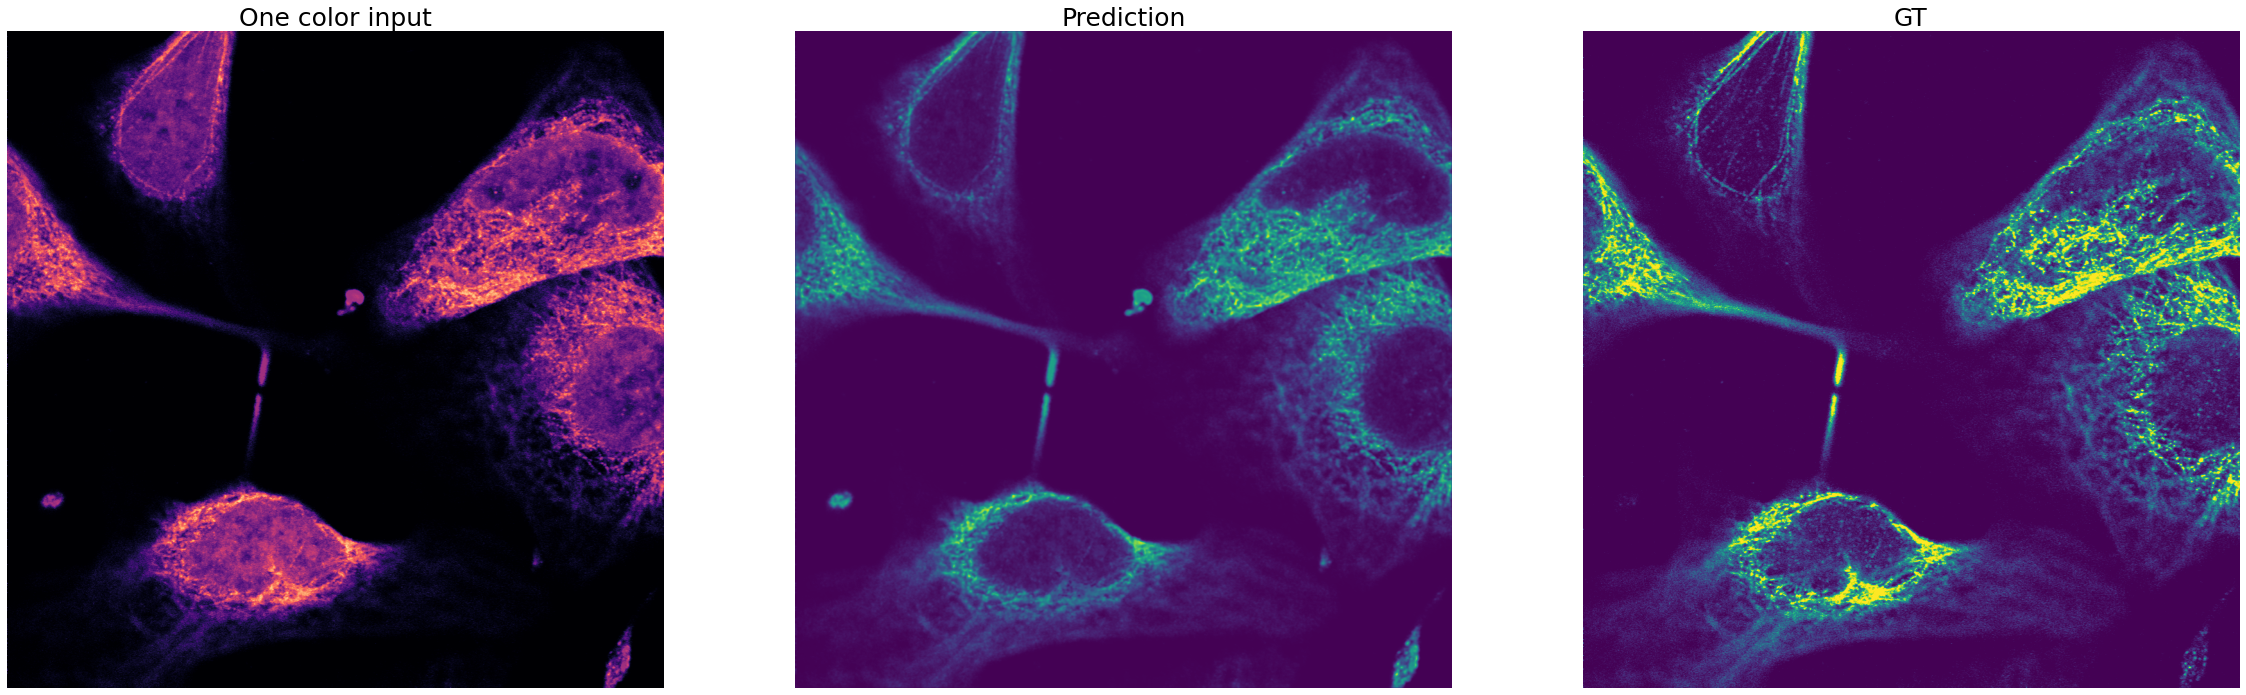

In [10]:
ix = np.random.randint(len(prediction1))
fig = plt.figure(figsize=(40, 20))
plt.subplot(1, 3, 1)
plt.imshow(x_test[ix].squeeze(), cmap='magma')
plt.title('One color input',fontdict={'fontsize':25})
plt.axis('off')

plt.subplot(1, 3,2)
plt.imshow(prediction1[ix].squeeze())
plt.title('Prediction',fontdict={'fontsize':25})
plt.axis('off')

plt.subplot(1, 3,3)
plt.imshow(y_test[ix].squeeze())
plt.title('GT',fontdict={'fontsize':25})
plt.axis('off')

In [ ]:
ssim_low =tf.image.ssim_multiscale(x_test, y_test, max_val = 1.0, filter_size=16,filter_sigma=1.5, k1=0.01, k2=0.03)
ssim_pred =tf.image.ssim_multiscale(prediction, y_test, max_val = 1.0, filter_size=16,filter_sigma=1.5, k1=0.01, k2=0.03)

ssim_low = ssim_low.numpy()
ssim_pred = ssim_pred.numpy()
print(ssim_pred)

sim = np.zeros((ssim_low.shape[0],2))
sim[:,0]=ssim_low
sim[:,1]=ssim_pred

In [ ]:
x_test1 = np.zeros((x_test.shape[0],2,x_test.shape[1],x_test.shape[2]),dtype=np.float32)
y_test1 = np.zeros((x_test.shape[0],2,x_test.shape[1],x_test.shape[2]),dtype=np.float32)
prediction1 = np.zeros((x_test.shape[0],2,x_test.shape[1],x_test.shape[2]),dtype=np.float32)
for i in range(2):
    x_test[:,:,:,i] = x_test[:,:,:,i]/x_test[:,:,:,i].max()
    x_test1[:,i,:,:]=x_test[:,:,:,i]
    y_test1[:,i,:,:]=y_test[:,:,:,i]
    prediction1[:,i,:,:]=prediction[:,:,:,i]

In [ ]:
from tifffile import imwrite
save_image_dr = "/content/drive/MyDrive/data/singlecolor_multicolor/results" 


pred1_test = np.moveaxis(prediction1,3,1)
X_test = np.moveaxis(x_test,3,1)
Y_test = np.moveaxis(y_test,3,1)


pred1_test = pred1_test*(2**16-1)
X_test = X_test*(2**16-1)
Y_test = Y_test*(2**16-1)

pred1_test = pred1_test.astype(np.uint16)
X_test = X_test.astype(np.uint16)
Y_test = Y_test.astype(np.uint16)

imwrite(save_image_dr+'/prediction.tif', pred1_test.squeeze(),imagej=True,metadata={'axes': 'TCYX'})
imwrite(save_image_dr+'/x_test.tif', X_test,imagej=True,metadata={'axes': 'TCYX'})
imwrite(save_image_dr+'/y_test.tif', Y_test.squeeze(),imagej=True,metadata={'axes': 'TCYX'})